<a href="https://colab.research.google.com/github/diegobarrera/kaggle-ML/blob/master/ProyectoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sector Atención al Cliente

"Recibimos muchas consultas de clientes a través de correo electrónico y chat. Nos gustaría poder clasificar automáticamente estas consultas por tema o urgencia para poder responder de forma más rápida y eficiente. ¿Podría la IA ayudarnos a hacerlo?"

## Cómo nos enfrentamos a un proyecto de IA?
* **Escogemos una o varias tareas a resolver**:

 Dado un texto proveniente de un correo o chat, poder clasificar la urgencia y el tema del mismo.

 **Inicialmente se hara solo la clasificacion de la urgencia**.

* **Escogemos una librería de software**

* **Creamos nuestro dataset etiquetado**:

 Idealmente el cliente podria proporcioinar ejemplos de los correos o chats, para poderlos etiquetar por **tema** y por **urgencia**.

 Dataset con labels https://huggingface.co/datasets/gorkemsevinc/customer_support_tickets

* **Escogemos n modelos**

  Debemos realizar dos clasificaciones, una para la urgencia y otra para el tema. Debido a que lo que debemos analizar es texto debemos hacer un encoding para poder crear un word embebbing y asi sea algo entendible para la maquina.
 * https://www.kaggle.com/code/yaminh/ticket-similarity-analysis-word2vec-faiss

* **Entrenamos**

* **Poner en marcha** (como quiere nuestro cliente que ejecutemos la solución)


In [163]:
import pandas as pd

df = pd.read_parquet("hf://datasets/gorkemsevinc/customer_support_tickets/data/train-00000-of-00001.parquet")

In [164]:
df.head()

,Customer Email,Product Purchased,Ticket Type,Ticket Subject,Combined Text,Ticket Priority
0,carrollallison@example.com,gopro hero,technical issue,product setup,i'm having an issue with the gopro hero. pleas...,critical
1,clarkeashley@example.com,lg smart tv,technical issue,peripheral compatibility,i'm having an issue with the lg smart tv. plea...,critical
2,gonzalestracy@example.com,dell xps,technical issue,network problem,i'm facing a problem with my dell xps. the del...,low
3,bradleyolson@example.org,microsoft office,billing inquiry,account access,i'm having an issue with the microsoft office....,low
4,bradleymark@example.com,autodesk autocad,billing inquiry,data loss,i'm having an issue with the autodesk autocad....,low


In [165]:
df.describe()

,Customer Email,Product Purchased,Ticket Type,Ticket Subject,Combined Text,Ticket Priority
count,8469,8469,8469,8469,8469,8469
unique,8320,42,5,16,8438,4
top,bsmith@example.com,canon eos,refund request,refund request,i'm having an issue with the google nest. plea...,medium
freq,4,240,1752,576,3,2192


In [166]:
df.isnull().sum()

,0
Customer Email,0
Product Purchased,0
Ticket Type,0
Ticket Subject,0
Combined Text,0
Ticket Priority,0


Dividir los datos de tests de los de train

20% - 80%

In [167]:
def preprocess(text):
    # Eliminar stop words, signos de puntuación, etc.
    # Puedes utilizar librerías como NLTK para un preprocesamiento más avanzado
    return text.lower()

df['Combined Text'] = df['Combined Text'].apply(preprocess)
df.head()

,Customer Email,Product Purchased,Ticket Type,Ticket Subject,Combined Text,Ticket Priority
0,carrollallison@example.com,gopro hero,technical issue,product setup,i'm having an issue with the gopro hero. pleas...,critical
1,clarkeashley@example.com,lg smart tv,technical issue,peripheral compatibility,i'm having an issue with the lg smart tv. plea...,critical
2,gonzalestracy@example.com,dell xps,technical issue,network problem,i'm facing a problem with my dell xps. the del...,low
3,bradleyolson@example.org,microsoft office,billing inquiry,account access,i'm having an issue with the microsoft office....,low
4,bradleymark@example.com,autodesk autocad,billing inquiry,data loss,i'm having an issue with the autodesk autocad....,low


In [168]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size] # from 0 to test_set_size
    train_indices = shuffled_indices[test_set_size:] # from test_set_size to len(data)
    # return a tuple
    return data.iloc[train_indices], data.iloc[test_indices]

In [169]:
train_set, test_set = shuffle_and_split_data(df, 0.2)
print(len(train_set), len(test_set))

6776 1693


In [170]:
X_train = train_set['Combined Text']
y_priority = train_set['Ticket Priority']
y_type = train_set['Ticket Type']

x_test = test_set['Combined Text']
y_test_priority = test_set['Ticket Priority']
y_test_type = test_set['Ticket Type']
# df_priority = df.drop(['Customer Email', 'Product Purchased', 'Ticket Subject', 'Ticket Type'], axis=1)

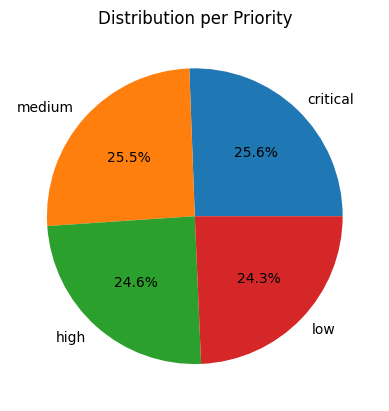

In [171]:
import matplotlib.pyplot as plt


priority_count = train_set["Ticket Priority"].value_counts()

plt.title('Distribution per Priority')
plt.pie(priority_count, labels=priority_count.index, autopct='%1.1f%%')
plt.show()



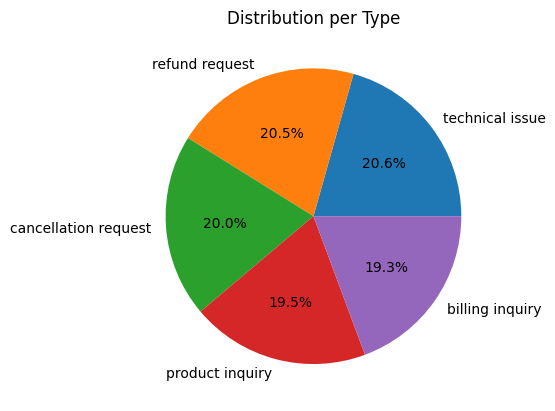

In [172]:

type_count = train_set["Ticket Type"].value_counts()

plt.title('Distribution per Type')
plt.pie(type_count, labels=type_count.index, autopct='%1.1f%%')
plt.show()

## Approach #1: Random Forest Classifier

In [173]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

In [174]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X_train)

In [175]:
model_rf = RandomForestClassifier(n_estimators=100)
model_rf.fit(X, y_priority)

RandomForestClassifier()

In [176]:
X_test = vectorizer.transform(x_test)
y_priority_pred = model_rf.predict(X_test)
# print(X_train)
# print(X_test)

In [177]:
fake_comment = ["This product is broken I want a refund"]
test = vectorizer.transform(fake_comment)
prediction = model_rf.predict(test)
prediction

array(['critical'], dtype=object)

In [178]:
fake_comment = ["exactly what I expected, the product is amazing!"]
test = vectorizer.transform(fake_comment)
prediction = model_rf.predict(test)
prediction

array(['critical'], dtype=object)

### Evaluar el accuracy

In [179]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test_priority, y_priority_pred)
print("Accuracy RandomForestClassifier:", accuracy)

Accuracy RandomForestClassifier: 0.26048434731246306


## Approach #2 - Support Vector Machine

In [180]:
from sklearn.svm import SVC

model_SVM = SVC()
model_SVM.fit(X, y_priority)

SVC()

In [181]:
y_priority_pred = model_SVM.predict(X_test)

In [182]:
accuracy = accuracy_score(y_test_priority, y_priority_pred)
print("Accuracy SVM:", accuracy)

Accuracy SVM: 0.2528056704075605


In [183]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer


vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X_train)

model_nb = MultinomialNB()
model_nb.fit(X, y_priority)

MultinomialNB()

In [184]:
X_test = vectorizer.transform(x_test)
y_priority_pred = model_nb.predict(X_test)

In [185]:
accuracy = accuracy_score(y_test_priority, y_priority_pred)
print("Accuracy Naive Bayes:", accuracy)

Accuracy Naive Bayes: 0.24571766095688127
